### Notebook to perform the training of a supervised model for the restoration of simulated nanoparticles suffering from tomographic reconstruction artefacts

*The data set consists of 2D images from simulated nanoparticles. The nanoparticles were already forward projected using tomosipo's Radon transform (0°:1°:180°), and reconstructed with limited number of projections in three scenarios using SIRT algorithm to mimic scenario from possibly real experimental acquisitions of nanoparticles :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

In [60]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imsave
import torch
from torch.utils.data import Dataset, DataLoader

dtype = torch.cuda.FloatTensor

plt.gray()

<Figure size 640x480 with 0 Axes>

#### Load train, test and validation data set and create the dataloaders

*Choose one of the three scenarios for the degraded acquisition*

In [43]:
reference = imread('../../Data/Simulated/simu_full.tif')

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3
paths = {
    1: "../../Data/Simulated/simu_mw60s2.tif",
    2: "../../Data/Simulated/simu_mw60s10.tif",
    3: "../../Data/Simulated/simu_mw30s2.tif",
}

degraded = imread(paths[ACQUISITION_CASE])

degraded = rearrange(torch.from_numpy(degraded).type(dtype), 'n x y -> n 1 x y')
reference = rearrange(torch.from_numpy(reference).type(dtype), 'n x y -> n 1 x y')

ref_train, ref_valid, ref_test = reference[:500], reference[500:550], reference[550:]
deg_train, deg_valid, deg_test = degraded[:500], degraded[500:550], degraded[550:]

In [44]:
class myTrainDataset(Dataset):
    def __init__(self, degraded_data, gt_data):
        self.degraded_data = degraded_data
        self.gt_data = gt_data

    def __len__(self):
        return self.degraded_data.shape[0]

    def __getitem__(self, idx):
        input_data = self.degraded_data[idx,:,:]
        ref_data = self.gt_data[idx,:,:]
        
        return input_data, ref_data

In [45]:
train_dataset = myTrainDataset(deg_train, ref_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = myTrainDataset(deg_valid, ref_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=True)

test_dataset = myTrainDataset(deg_test, ref_test)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#### Network, training parameters and training loop

In [47]:
EPOCHS = 20
LR = 3e-4

ud_filters, skip_filters = [32,64,128], [8,16,32]
n_scale = len(ud_filters)
model = model_unet(input_shape=1,
            down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
            down_kernels=[3]*len(ud_filters), up_kernels=[3]*len(ud_filters), skip_kernels=[1]*len(ud_filters),
            up_mode='bilinear', down_mode='stride', pad_mode='reflect'
           ).to('cuda').type(dtype)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [48]:
global_train_loss = []
global_val_loss = []

for epoch in range(EPOCHS):

    model.train()

    epoch_loss = []
    
    loop = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for train_data, gt_train_data in loop:

        for param in model.parameters():
            param.grad = None

        out = model(train_data)

        loss = l1_mssim_loss(out, gt_train_data)

        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())

    global_train_loss.append(np.mean(epoch_loss))

    model.eval()
    val_epoch_loss = []
    with torch.no_grad():
        for val_data, gt_val_data in valid_dataloader:
            val_out = model(val_data)
            val_loss = l1_mssim_loss(val_out, gt_val_data)
            val_epoch_loss.append(val_loss.item())
        global_val_loss.append(np.mean(val_epoch_loss))

    print(f'Training loss {global_train_loss[-1]:.3f} - Validation loss {global_val_loss[-1]:.3f}')

Epoch 1/20: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]


Training loss 0.023 - Validation loss 0.016


Epoch 2/20: 100%|██████████| 125/125 [00:16<00:00,  7.69it/s]


Training loss 0.014 - Validation loss 0.012


Epoch 3/20: 100%|██████████| 125/125 [00:17<00:00,  7.21it/s]


Training loss 0.011 - Validation loss 0.011


Epoch 4/20: 100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Training loss 0.010 - Validation loss 0.010


Epoch 5/20: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]


Training loss 0.009 - Validation loss 0.009


Epoch 6/20: 100%|██████████| 125/125 [00:16<00:00,  7.71it/s]


Training loss 0.009 - Validation loss 0.008


Epoch 7/20: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 0.008 - Validation loss 0.008


Epoch 8/20: 100%|██████████| 125/125 [00:16<00:00,  7.67it/s]


Training loss 0.008 - Validation loss 0.008


Epoch 9/20: 100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Training loss 0.007 - Validation loss 0.008


Epoch 10/20: 100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Training loss 0.007 - Validation loss 0.007


Epoch 11/20: 100%|██████████| 125/125 [00:16<00:00,  7.60it/s]


Training loss 0.007 - Validation loss 0.008


Epoch 12/20: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]


Training loss 0.007 - Validation loss 0.008


Epoch 13/20: 100%|██████████| 125/125 [00:16<00:00,  7.71it/s]


Training loss 0.006 - Validation loss 0.008


Epoch 14/20: 100%|██████████| 125/125 [00:16<00:00,  7.64it/s]


Training loss 0.006 - Validation loss 0.007


Epoch 15/20: 100%|██████████| 125/125 [00:16<00:00,  7.68it/s]


Training loss 0.006 - Validation loss 0.008


Epoch 16/20: 100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Training loss 0.006 - Validation loss 0.008


Epoch 17/20: 100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Training loss 0.006 - Validation loss 0.008


Epoch 18/20: 100%|██████████| 125/125 [00:16<00:00,  7.70it/s]


Training loss 0.006 - Validation loss 0.007


Epoch 19/20: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 0.006 - Validation loss 0.007


Epoch 20/20: 100%|██████████| 125/125 [00:16<00:00,  7.72it/s]


Training loss 0.006 - Validation loss 0.007


Text(0.5, 1.0, 'Evolution of the training and validation loss during the training of the model')

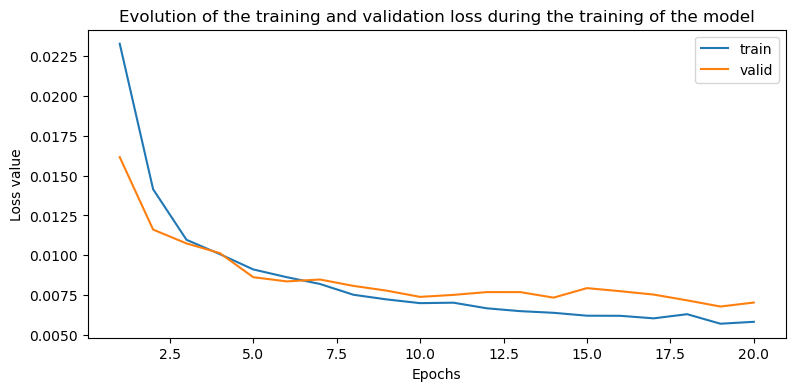

In [50]:
plt.figure(figsize=(9,4))
plt.plot(list(range(1,EPOCHS+1)), global_train_loss, label='train')
plt.plot(list(range(1,EPOCHS+1)), global_val_loss, label='valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Evolution of the training and validation loss during the training of the model')

#### Application to test data not used during training and validation

In [51]:
test_reco_list = []
for test_data, _ in test_dataloader:
    out_test = model(test_data)
    test_reco_list.append(simplify(out_test))

Text(0.5, 1.0, 'SIRT reference reconstruction')

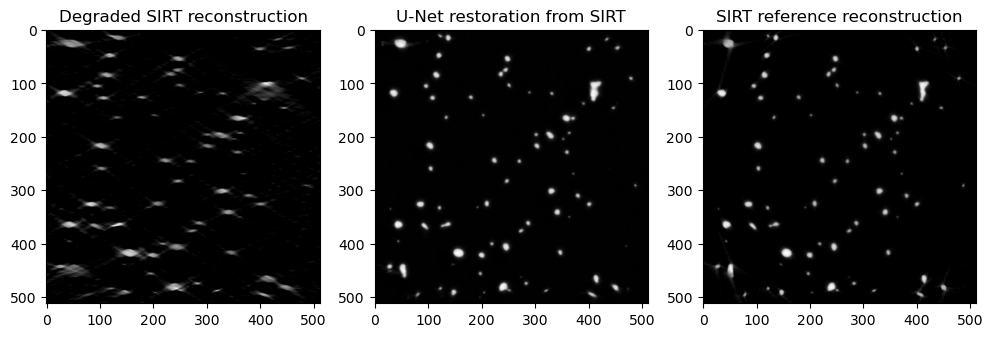

In [52]:
# Chose image index in [0 - 50] from the test data set
data_index = 15

fig, ((ax0, ax1, ax2)) = plt.subplots(1, 3, figsize = (12,8))
ax0.imshow(simplify(deg_test[data_index,:,:]))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(test_reco_list[data_index]))
ax1.set_title('U-Net restoration from SIRT')
ax2.imshow(simplify(ref_test[data_index]))
ax2.set_title('SIRT reference reconstruction')

#### Save the trained model weights and restored image

In [64]:
from pathlib import Path

OUT_PATH = Path("../../Temp_out")
if not OUT_PATH.is_dir():
    OUT_PATH.mkdir()

imsave(f'{OUT_PATH}/out_simu_supervised_{ACQUISITION_CASE}.tif', simplify(test_reco_list[data_index]))
torch.save(model.state_dict(), f'{OUT_PATH}/model_simu_supervised_{ACQUISITION_CASE}.pth')